## Predict the overall rating of soccer player
Data used here came from Kaggle dataset of European Soccer Database

In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow.parquet as pq
import numpy as np


In [7]:
#Reading parquet file data
## Converting parquet file to pandas dataframe
data = pq.read_pandas('soccer.parquet').to_pandas()
data.head()

,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
id,,,,,,,,,,,,,,,,,,,,,
1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [10]:
##Checking for missing data
print(data.isna().sum())


player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle      

#### Dropping missing data

In [11]:
len(data),len(data.dropna())

(183978, 180354)

In [12]:
data = data.dropna()

### Visualizing the data

<AxesSubplot:ylabel='Frequency'>

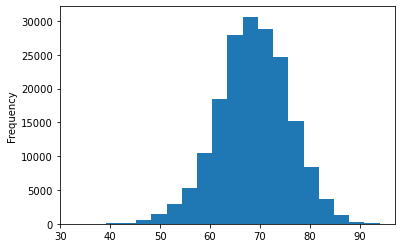

In [13]:
data['overall_rating'].plot.hist(bins = 20)

In [14]:
data['overall_rating'].describe()

count    180354.000000
mean         68.635317
std           7.027950
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

#### Selecting important features

In [19]:
data.corr()['overall_rating'].sort_values(ascending = False)

overall_rating        1.000000
reactions             0.771856
potential             0.765435
short_passing         0.458243
ball_control          0.443991
long_passing          0.434525
vision                0.431493
shot_power            0.428053
penalties             0.392715
long_shots            0.392668
positioning           0.368978
volleys               0.361739
curve                 0.357566
crossing              0.357320
dribbling             0.354191
free_kick_accuracy    0.349800
finishing             0.330079
stamina               0.325606
aggression            0.322782
strength              0.315684
heading_accuracy      0.313324
jumping               0.258978
sprint_speed          0.253048
interceptions         0.249094
acceleration          0.243998
agility               0.239963
standing_tackle       0.163986
balance               0.160211
marking               0.132185
sliding_tackle        0.128054
gk_kicking            0.028799
gk_diving             0.027675
gk_posit

In [21]:
#Selecting top 10 correlated features
x = data[['reactions', 'potential', 'short_passing', 'ball_control', 'long_passing', 'vision', 'shot_power','penalties','long_shots','positioning','volleys']]
y = data['overall_rating']

### Splitting data into training and test datasets

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3 , random_state = 42)

#### Training our model with 70% of dataset

In [36]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

### Evaluating the Model with R2-score

In [37]:

y_predict = model.predict(x_test)
r2_score(y_test,y_predict)

0.7599893472749943

#### R2 score is not that bad but still it needed to be improved. We have to look into the best indicators of a player rating

#### We can also use clustering method to improve the performance of our model